In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb
from astropy.visualization import ZScaleInterval, LinearStretch, ImageNormalize
import astropy.units as u
import gc
import uuid
import glob
from PIL import Image

import lsst.afw.display as afwDisplay
from lsst.afw.image import MultibandExposure
from lsst.daf.butler import Butler
import lsst.geom as geom
from lsst.afw.image import Exposure, ExposureF
from lsst.pipe.tasks.registerImage import RegisterConfig, RegisterTask

# PyVO packages
import pyvo
from pyvo.dal.adhoc import DatalinkResults, SodaQuery

from lsst.rsp import get_tap_service

In [2]:
afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')
%matplotlib inline

In [3]:
service = get_tap_service("tap")

In [4]:
butler = Butler('dp02', collections='2.2i/runs/DP0.2')

In [5]:
plt.style.use('tableau-colorblind10')

plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

In [6]:
DiaObjID = 1250953961339360185
print(DiaObjID)

1250953961339360185


In [7]:
results = service.search("SELECT fsodo.coord_ra, fsodo.coord_dec, "\
                         "fsodo.diaObjectId, fsodo.ccdVisitId, fsodo.band, "\
                         "fsodo.psfDiffFlux, fsodo.psfDiffFluxErr, "\
                         "fsodo.psfFlux, fsodo.psfFluxErr, "\
                         "cv.expMidptMJD "\
                         "FROM dp02_dc2_catalogs.ForcedSourceOnDiaObject as fsodo "\
                         "JOIN dp02_dc2_catalogs.CcdVisit as cv ON cv.ccdVisitId = fsodo.ccdVisitId "\
                         "WHERE fsodo.diaObjectId = "+str(DiaObjID))

In [8]:
forcedSrc = results.to_table()
forcedSrc
del results

In [9]:
forcedSrc

coord_ra,coord_dec,diaObjectId,ccdVisitId,band,psfDiffFlux,psfDiffFluxErr,psfFlux,psfFluxErr,expMidptMJD
deg,deg,,,,nJy,nJy,nJy,nJy,d
float64,float64,int64,int64,object,float64,float64,float64,float64,float64
60.2901401,-44.142051,1250953961339360185,306218162,y,-1860.8964904,1756.6612246,-2182.6809799,1748.0130297,60009.0613732
60.2901401,-44.142051,1250953961339360185,944022184,g,3466.5007161,107.5929099,3434.206355,105.083586,60962.1845452
60.2901401,-44.142051,1250953961339360185,677658160,u,142.8869939,173.2933283,135.5984978,178.6943917,60585.2000022
60.2901401,-44.142051,1250953961339360185,201707083,r,-487.1626094,172.1758637,-362.5391704,171.8586311,59853.2530172
60.2901401,-44.142051,1250953961339360185,668152065,y,-1589.8833975,1174.136922,-1631.4208407,1200.0504808,60571.2881552
60.2901401,-44.142051,1250953961339360185,969979156,r,58.9247711,220.5372728,176.8572168,220.0953768,61007.1773932
60.2901401,-44.142051,1250953961339360185,1038222133,r,6.5545737,127.9273197,130.2734536,127.191395,61107.0516742
60.2901401,-44.142051,1250953961339360185,430217116,g,-10.9406254,82.5641558,-32.9963024,80.2975946,60196.3131982


In [10]:
results = service.search("SELECT ra, decl, diaObjectId, diaSourceId, psFlux, psFluxErr, "
                         "filterName, midPointTai, SNR, ccdVisitId, "
                         "scisql_nanojanskyToAbMag(psFlux) AS psAbMag "
                         "FROM dp02_dc2_catalogs.DiaSource "
                         "WHERE diaObjectId = "+str(DiaObjID))
diaSrc = results.to_table()
del results

In [11]:
diaSrc

ra,decl,diaObjectId,diaSourceId,psFlux,psFluxErr,filterName,midPointTai,SNR,ccdVisitId,psAbMag
deg,deg,,,nJy,nJy,,,,,
float64,float64,int64,int64,float64,float64,object,float64,float64,int64,float64
60.2901125,-44.1420786,1250953961339360185,501440721752948798,10728.1910979,298.7996759,i,60949.2700942,13.0800548,934006128,21.323683747840736
60.2902053,-44.1420999,1250953961339360185,519058666863722611,1872.4150715,249.4993408,i,61003.0663112,3.4689005,966822108,23.218994679485633
60.290094,-44.1420676,1250953961339360185,519058126771585128,2118.1968895,255.2405367,i,61003.0658612,3.0083032,966821102,23.08508418511191
60.2901202,-44.1420255,1250953961339360185,501445526210740341,10984.0687235,305.5120371,i,60949.2745512,15.3669647,934015077,21.298091896332963
60.2900628,-44.1420546,1250953961339360185,519040893215310007,2299.9806841,254.1940593,i,61003.0514492,1.8747777,966789002,22.995689528242984
60.2901395,-44.1420251,1250953961339360185,506834128545513606,3306.9228607,100.3718771,g,60962.1981072,13.7650611,944052131,22.60143983896541
60.2901823,-44.1420645,1250953961339360185,506816399457386594,3275.3988351,106.0072236,g,60962.1831932,14.0158793,944019108,22.61183952441946
60.290121,-44.1420711,1250953961339360185,506932912256450747,3265.3097855,108.5430791,g,60962.2831282,9.5723258,944236130,22.6151890254431


In [12]:
forcedSrc['DiffSNR'] = abs(forcedSrc['psfDiffFlux']/forcedSrc['psfDiffFluxErr'])

In [13]:
mjd_full_start = np.min(forcedSrc['expMidptMJD'])
mjd_full_end = np.max(forcedSrc['expMidptMJD'])

mjd_det_start = np.min(diaSrc['midPointTai'])
mjd_det_end = np.max(diaSrc['midPointTai'])

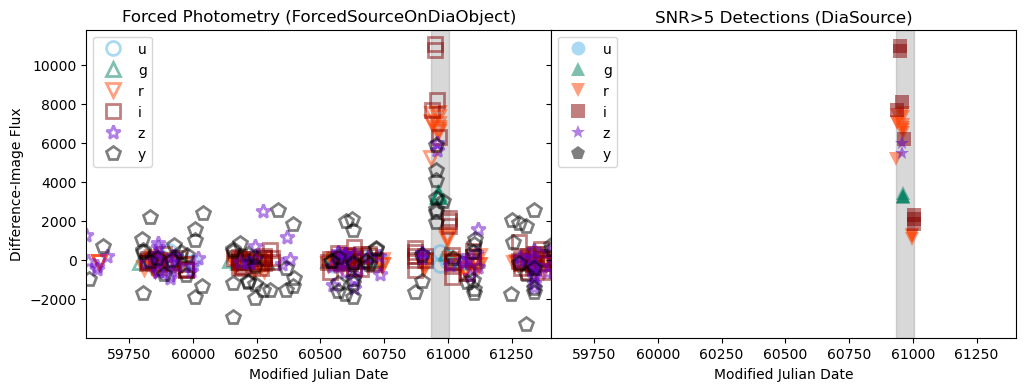

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True, sharex=False)

for f, filt in enumerate(plot_filter_labels):
    fx = np.where(forcedSrc['band'] == filt)[0]
    ax[0].plot(forcedSrc['expMidptMJD'][fx], forcedSrc['psfDiffFlux'][fx],
               plot_filter_symbols[filt], ms=10, mew=2, mec=plot_filter_colors[filt],
               alpha=0.5, color='none', label=filt)
    del fx

ax[0].set_xlabel('Modified Julian Date')
ax[0].set_ylabel('Difference-Image Flux')
ax[0].set_title('Forced Photometry (ForcedSourceOnDiaObject)')
ax[0].set_xlim(mjd_full_start, mjd_full_end)
ax[0].legend(loc='upper left')
ax[0].axvspan(mjd_det_start, mjd_det_end, alpha=0.3, color='gray')

for f, filt in enumerate(plot_filter_labels):
    fx = np.where(diaSrc['filterName'] == filt)[0]
    ax[1].plot(diaSrc['midPointTai'][fx], diaSrc['psFlux'][fx],
               plot_filter_symbols[filt], ms=10, mew=0, color=plot_filter_colors[filt],
               alpha=0.5, label=filt)
    del fx

ax[1].set_xlabel('Modified Julian Date')
ax[1].set_title('SNR>5 Detections (DiaSource)')
ax[1].set_xlim(mjd_full_start, mjd_full_end)
ax[1].legend(loc='upper left')
ax[1].axvspan(mjd_det_start, mjd_det_end, alpha=0.3, color='gray')
plt.subplots_adjust(wspace=.0)

plt.show()

In [15]:
def make_image_cutout(butler, tap_service, ra, dec, cutout_size=0.01, imtype=None, visit=None, detector=None, filename=None):
    """Make a cutout using the cutout tool
   
   Parameters
    ----------
    # cutout_size is in degrees
    # i think we need to add option to request calexp vs deepcoadd
   
   Returns
    -------
    
    """

    spherePoint = geom.SpherePoint(ra*geom.degrees, dec*geom.degrees)
    registry = butler.registry
    if imtype == 'calexp':
        dataId = {'visit':visit, 'detector':detector}

        # Need the UUID of the image for the cutout service 
        datasetRef = registry.findDataset('calexp', dataId)

        calexp_uuid = datasetRef.id
        assert isinstance(calexp_uuid, uuid.UUID)
        f"UUID for calexp: {calexp_uuid}"

        query = "SELECT access_format, access_url, dataproduct_subtype, lsst_visit, lsst_detector, " + \
            "lsst_band, s_ra, s_dec FROM ivoa.ObsCore WHERE dataproduct_type = 'image' " + \
            "AND obs_collection = 'LSST.DP02' " + \
            "AND dataproduct_subtype = 'lsst.calexp' " + \
            "AND lsst_visit = " + str(visit) + " " + \
            "AND lsst_detector = " + str(detector)
        results = tap_service.search(query) # THIS IS TAP SERVICE

    else:
        # Find the tract and patch that contain this point
        skymap = butler.get('skyMap')
        tract = skymap.findTract(spherePoint)
        patch = tract.findPatch(spherePoint)

        # Now create a dataId from the tract, patch and filter information
        dataId = {'band':'i', 'tract':tract.tract_id, 'patch': patch.getSequentialIndex()}

        # Need the UUID of the image for the cutout service 
        datasetRef = registry.findDataset('deepCoadd_calexp', dataId)
    
        deepCoadd_uuid = datasetRef.id
        assert isinstance(deepCoadd_uuid, uuid.UUID)
        f"UUID for deep coadd: {deepCoadd_uuid}"

        #Get from dataID (needs to be fixed)
        t = tract.tract_id
        p = patch.getSequentialIndex()

        query = "SELECT access_format, access_url, dataproduct_subtype, lsst_patch, lsst_tract, " + \
            "lsst_band, s_ra, s_dec FROM ivoa.ObsCore WHERE dataproduct_type = 'image' " + \
            "AND obs_collection = 'LSST.DP02' " + \
            "AND dataproduct_subtype = 'lsst.deepCoadd_calexp' " + \
            "AND lsst_tract = " + str(t) + " " + \
            "AND lsst_patch = " + str(p) + " " + \
            "AND lsst_band = 'i' "
        results = tap_service.search(query) # THIS IS TAP SERVICE

    #Get datalink
    dataLinkUrl = results[0].getdataurl()
    f"Datalink link service url: {dataLinkUrl}"
    auth_session = service._session
    dl_results = DatalinkResults.from_result_url(dataLinkUrl,session=auth_session)
    f"{dl_results.status}"

    sq = SodaQuery.from_resource(dl_results, dl_results.get_adhocservice_by_id("cutout-sync"), 
                                 session=auth_session)

    sq.circle = (spherePoint.getRa().asDegrees()* u.deg,
                 spherePoint.getDec().asDegrees()*u.deg, 
                 cutout_size* u.deg)

    #sodaCutout = os.path.join(os.getenv('HOME'), 'DATA/soda-cutout.fits')
    if filename:
        sodaCutout = 'cutouts/'+filename
    else:
        sodaCutout = 'cutouts/soda-cutout.fits'

    with open(sodaCutout, 'bw') as f:
        f.write(sq.execute_stream().read())
    
    return sodaCutout


In [16]:
def cutout_calexp(butler, ra, dec, visit, detector, cutoutSideLength=51, **kwargs):
    
    """
    Produce a cutout from a calexp at the given ra, dec position.

    Adapted from cutout_coadd which was adapted from a DC2 tutorial
    notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    visit: int
        Visit id of the calexp's visit
    detector: int
        Detector for the calexp
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    
    dataId = {'visit': visit, 'detector': detector}    
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)    
    calexp_wcs = butler.get('calexp.wcs', **dataId)
    xy = geom.PointI(calexp_wcs.skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    parameters = {'bbox': bbox}
    cutout_image = butler.get('calexp', parameters=parameters, **dataId)

    return cutout_image

## Define the function that makes the animated GIF:

In [17]:
def make_gif(frame_folder):
    frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*.png"))]
    frame_one = frames[0]
    frame_one.save("animation.gif", format="GIF", append_images=frames,
               save_all=True, duration=500, loop=1)


## Now put these into action. First, make cutouts using the butler:

In [18]:
# Sort the source catalog by observation time:
diaSrc.sort('midPointTai')


In [19]:
ra = forcedSrc[0]['coord_ra']
dec = forcedSrc[0]['coord_dec']
ccdvisitID = diaSrc[10]['ccdVisitId']

visit = str(ccdvisitID)[:-3]
detector = str(ccdvisitID)[-3:]
visit = int(visit)
detector = int(detector)

print(visit, detector, ra, dec)


942690 13 60.2901401 -44.142051


## Make the cutouts with the SODA service:

## Rotate the cutouts to be in the same orientation

In [20]:
def warp_img(ref_img, img_to_warp, ref_wcs, wcs_to_warp):

    config = RegisterConfig()
    task = RegisterTask(name="register", config=config)
    warpedExp = task.warpExposure(img_to_warp, wcs_to_warp, ref_wcs,
                                  ref_img.getBBox())

    return warpedExp

In [21]:
def get_minmax_xy(img, cutout_size):

    cutout_size = int(cutout_size)
    
    height = img.height
    width = img.width

    ceny = (height - 1) / 2
    cenx = (width - 1) / 2

    minx = int(cenx - ((cutout_size - 1) / 2))
    maxx = int(cenx + ((cutout_size - 1) / 2))
    miny = int(ceny - ((cutout_size - 1) / 2))
    maxy = int(ceny + ((cutout_size - 1) / 2))

    return {'minx':minx, 'maxx':maxx, 'miny':miny, 'maxy':maxy}

In [25]:
if os.path.exists('cutouts'):
    print('cutouts/ directory already exists')
else:
    os.mkdir('cutouts')
    print('Made a cutouts/ directory')

if os.path.exists('images'):
    print('images/ directory already exists')
else:
    os.mkdir('images')
    print('Made an images/ directory')

ii = 0
cutout_size_pix = 131

picksrc = (diaSrc['filterName'] == 'r')

for src in diaSrc[picksrc]:
# for src in diaSrc:
    ccdvisitID = src['ccdVisitId']
    visit = str(ccdvisitID)[:-3]
    detector = str(ccdvisitID)[-3:]
    visit = int(visit)
    detector = int(detector)

    if ii == 0:
        # 0.2-arcsec pixels, convert to degrees
        cutout_size = (cutout_size_pix*2) * 0.2/3600.0

        # Make the first image the reference image that we'll warp all the others to.
        fitsname = 'cutout_ref.fits'
        make_image_cutout(butler, service, ra, dec, cutout_size=cutout_size, imtype='calexp',
                          visit=visit, detector=detector, filename=fitsname)
        img_ref = ExposureF('cutouts/'+fitsname)
    else:
        cutout_size = (cutout_size_pix*1.1) * 0.2/3600.0

    ii += 1
    
    try:
        fitsname = 'cutout_'+str(src['diaSourceId'])+'.fits'
        make_image_cutout(butler, service, ra, dec, cutout_size=cutout_size, imtype='calexp',
                          visit=visit, detector=detector, filename=fitsname)
        img = ExposureF('cutouts/'+fitsname)

        img_warped = warp_img(img_ref, img, img_ref.getWcs(), img.getWcs())
        
        fig, ax = plt.subplots()

        minmax = get_minmax_xy(img_warped, cutout_size_pix)
        im_arr = img_warped.image.array[minmax['minx']:minmax['maxx'], minmax['miny']:minmax['maxy']]
        im_arr_bgnorm = im_arr/np.nanmedian(im_arr)
        
        # Create an ImageNormalize object
        norm = ImageNormalize(im_arr_bgnorm, interval=ZScaleInterval(),
                              stretch=LinearStretch())
        
        # plt.imshow(im_arr_bgnorm, origin='lower', norm=norm, cmap='gray')
        plt.imshow(im_arr_bgnorm, origin='lower', vmin=-200, vmax=300, cmap='gray')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.title('MJD: '+str(src['midPointTai'])+'; band: '+str(src['filterName']))
        figname = 'images/cutout_'+str(src['diaSourceId'])+'.png'
        if os.path.isfile(figname):
            os.remove(figname)
        plt.savefig(figname)
        plt.close()
    except:
        print('Calexp not found for source '+str(src['diaSourceId']))

cutouts/ directory already exists
images/ directory already exists


In [26]:
make_gif('images')